**What This Script Does (Big Picture)**

1. Takes a pre-trained model that learned to classify heart disease from gene
expression

2. Processes new cell data through this model

3. Extracts "learned representations" (embeddings) that capture disease-relevant patterns

4. Visualizes these representations to see if:

a. Healthy cells cluster together

b. DCM cells cluster together

c. HCM cells cluster together

The model learned meaningful disease signatures.

**Section 1: Initialize EmbExtractor**

```
embex = EmbExtractor(model_type="CellClassifier",
                     num_classes=3,
                     filter_data={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]},
                     max_ncells=1000,
                     emb_layer=0,
                     emb_label=["disease","cell_type"],
                     labels_to_plot=["disease"],
                     forward_batch_size=200,
                     model_version="V1",
                     nproc=16)
```

Parameters explained:

*model_type="CellClassifier"*- Using a cell classification model

*num_classes=3*- Three disease classes: DCM, HC, Normal

*filter_data={"cell_type":[...]}*- Only process these specific cardiomyocyte cell types

*max_ncells=1000*- Maximum number of cells to process

*emb_layer=0*- Extract embeddings from layer 0 (input layer)

*emb_label=["disease","cell_type"]*- Use both disease and cell type labels

*labels_to_plot=["disease"]* - Visualize by disease classification

*forward_batch_size=200* - Process 200 cells at a time

*model_version="V1"*- Use V1 Geneformer model

*nproc=16* - Use 16 CPU cores for processing

**Section 2: Extract Embeddings**

```
embs = embex.extract_embs("../fine_tuned_models/
Geneformer-V1-10M_CellClassifier_cardiomyopathies_220224",
                          "path/to/input_data/",
                          "path/to/output_directory/",
                          "output_prefix")
```

This function:

Takes a **fine-tuned model** (specifically trained on cardiomyopathy data)

Processes **tokenized gene expression data** (not raw scRNA-seq)

Outputs **high-dimensional embeddings** representing each cell

Saves results to specified directory with a** prefix**

**Section 3: Create UMAP Visualization**

```
embex.plot_embs(embs=embs,
                plot_style="umap",
                output_directory="path/to/output_directory/",
                output_prefix="emb_plot")
```


**Section 4: Create Heatmap**

```
embex.plot_embs(embs=embs,
                plot_style="heatmap",
                output_directory="path/to/output_directory/",
                output_prefix="emb_plot")
```

Shows embedding values as a color-coded matrix :

Each row = one cell

Each column = one embedding dimension


In [1]:
!pip install -U transformers
!pip install -q huggingface_hub

In [2]:
# Cell 1: Git LFS installation and repository cloning
# Install git-lfs
!sudo apt-get update
!sudo apt-get install -y git-lfs
!git lfs install

# Clone the Geneformer repository
!git clone https://huggingface.co/ctheodoris/Geneformer

# Cell 2: Install the Geneformer Python package
!cd Geneformer && pip install .

# Optional: Verify installation by importing
import os
import sys
# Add the cloned repo's directory to sys.path if 'pip install .' doesn't make it available immediately
# (Sometimes Colab needs a restart, but this can help)
if '/content/Geneformer' not in sys.path:
    sys.path.insert(0, '/content/Geneformer')

from geneformer import Classifier, EmbExtractor
print("Geneformer imported successfully!")

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [3]:
!ls /content/Geneformer

build		   geneformer.egg-info		MANIFEST.in
config.json	   Geneformer-V1-10M		model.safetensors
docs		   Geneformer-V2-104M		README.md
examples	   Geneformer-V2-104M_CLcancer	requirements.txt
fine_tuned_models  Geneformer-V2-316M		setup.py
geneformer	   generation_config.json	training_args.bin


In [4]:
from geneformer import EmbExtractor

In [5]:
# Create the directory
# !mkdir -p /content/Genecorpus-30M

# Clone with sparse checkout for only example_input_files
# !git clone --filter=blob:none --sparse https://huggingface.co/datasets/ctheodoris/Genecorpus-30M /content/Genecorpus-30M

# Configure sparse checkout to only include example_input_files
# !cd /content/Genecorpus-30M && git sparse-checkout set example_input_files

# Check what was downloaded
# !ls -la /content/Genecorpus-30M/
# !find /content/Genecorpus-30M -type f -name "*.dataset"

In [6]:
# Clone only the `example_input_files` folder
!git clone --filter=blob:none --no-checkout https://huggingface.co/datasets/ctheodoris/Genecorpus-30M
%cd Genecorpus-30M
!git sparse-checkout init --cone
!git sparse-checkout set example_input_files
!git checkout main

fatal: destination path 'Genecorpus-30M' already exists and is not an empty directory.
/content/Genecorpus-30M
Encountered 1 file(s) that may not have been copied correctly on Windows:
	example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset/dataset.arrow

See: `git lfs help smudge` for more details.
Already on 'main'
Your branch is up to date with 'origin/main'.


In [7]:
!cd /content/
!pwd

from huggingface_hub import snapshot_download
import os

# Create directory
os.makedirs("/content/datasets", exist_ok=True)

# Download only the disease_classification directory
dataset_path = snapshot_download(
    repo_id="ctheodoris/Genecorpus-30M",
    repo_type="dataset",
    local_dir="/content/datasets",
    local_dir_use_symlinks=False,
    allow_patterns="example_input_files/cell_classification/disease_classification/*"
)

print(f"Downloaded to: {dataset_path}")
!ls -la /content/datasets/example_input_files/cell_classification/disease_classification/

/content/Genecorpus-30M


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Downloaded to: /content/datasets
total 12
drwxr-xr-x 3 root root 4096 Jun 25 17:49 .
drwxr-xr-x 3 root root 4096 Jun 25 17:49 ..
drwxr-xr-x 2 root root 4096 Jun 25 17:49 human_dcm_hcm_nf.dataset


In [8]:
!pwd
!ls -la ./Geneformer/fine_tuned_models/

/content/Genecorpus-30M
ls: cannot access './Geneformer/fine_tuned_models/': No such file or directory


In [9]:
!pwd
!echo "-------"
%cd /content/
!pwd
!echo "-------"
!ls -1
!echo "-------"
!echo "Genecorpus-30M"
!ls -1 /content/Genecorpus-30M
!echo "-------"
!ls -1
!echo "-------"
!echo "Geneformer"
!ls -1 /content/Geneformer
!echo "-------"
!echo "datasets"
!ls -1 /content/datasets
!echo "-------"

/content/Genecorpus-30M
-------
/content
/content
-------
cardiomyopathy_cell_classification_250625
datasets
Genecorpus-30M
Geneformer
sample_data
-------
Genecorpus-30M
example_input_files
genecorpus_30M_2048_lengths.pkl
genecorpus_30M_2048_sorted_lengths.pkl
README.md
token_dictionary.pkl
-------
cardiomyopathy_cell_classification_250625
datasets
Genecorpus-30M
Geneformer
sample_data
-------
Geneformer
build
config.json
docs
examples
fine_tuned_models
geneformer
geneformer.egg-info
Geneformer-V1-10M
Geneformer-V2-104M
Geneformer-V2-104M_CLcancer
Geneformer-V2-316M
generation_config.json
MANIFEST.in
model.safetensors
README.md
requirements.txt
setup.py
training_args.bin
-------
datasets
example_input_files
-------


In [10]:
!echo "fined tune model"
!ls -la /content/Geneformer/fine_tuned_models/Geneformer-V1-10M_CellClassifier_cardiomyopathies_220224/
!echo "----------------------"
!echo "disease classification"
!ls -1 Genecorpus-30M/example_input_files/cell_classification/disease_classification
!ls -1 Genecorpus-30M/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset

fined tune model
total 112192
drwxr-xr-x 2 root root     4096 Jun 25 17:46 .
drwxr-xr-x 3 root root     4096 Jun 25 17:46 ..
-rw-r--r-- 1 root root      930 Jun 25 17:46 config.json
-rw-r--r-- 1 root root 73720721 Jun 25 17:46 optimizer.pt
-rw-r--r-- 1 root root 41115113 Jun 25 17:46 pytorch_model.bin
-rw-r--r-- 1 root root    14657 Jun 25 17:46 rng_state.pth
-rw-r--r-- 1 root root      623 Jun 25 17:46 scheduler.pt
-rw-r--r-- 1 root root     3726 Jun 25 17:46 trainer_state.json
-rw-r--r-- 1 root root     2607 Jun 25 17:46 training_args.bin
----------------------
disease classification
human_dcm_hcm_nf.dataset
dataset.arrow
dataset_info.json
state.json


In [11]:
!echo "gene dictionaries"
!ls -la /content/Geneformer/geneformer/gene_dictionaries_30m

import os

# Verify the file exists
token_path = "/content/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"
print(f"Token dictionary exists: {os.path.exists(token_path)}")
print(f"Full path: {os.path.abspath(token_path)}")

# List all token files to see what's available
!ls -la /content/Geneformer/geneformer/*token*

gene dictionaries
total 3364
drwxr-xr-x 2 root root    4096 Jun 25 17:46 .
drwxr-xr-x 5 root root    4096 Jun 25 17:47 ..
-rw-r--r-- 1 root root  584125 Jun 25 17:46 ensembl_mapping_dict_gc30M.pkl
-rw-r--r-- 1 root root  940965 Jun 25 17:46 gene_median_dictionary_gc30M.pkl
-rw-r--r-- 1 root root 1117117 Jun 25 17:46 gene_name_id_dict_gc30M.pkl
-rw-r--r-- 1 root root  788424 Jun 25 17:46 token_dictionary_gc30M.pkl
Token dictionary exists: True
Full path: /content/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
-rw-r--r-- 1 root root 425590 Jun 25 17:46 /content/Geneformer/geneformer/token_dictionary_gc104M.pkl
-rw-r--r-- 1 root root  30666 Jun 25 17:46 /content/Geneformer/geneformer/tokenizer.py


In [12]:
# What is <cls>?

# The <cls> token is prepended to the input sequence.
# It stands for "classification", and is meant to capture a summary representation of the entire input.
# After passing the sequence through the Transformer, the final hidden state corresponding to the <cls> token is typically used as the aggregate representation for classification tasks.

# GPT4 info : it might not be accurate !

# Geneformer V1 and V2 both utilize a special <cls> token in their transformer models — but with some differences in implementation and usage context.

# 🔹 Geneformer V1
# Based on BERT architecture, which uses the <cls> token at the start of the input.
# The <cls> token embedding is used for tasks like cell classification, gene embedding extraction, and regression.
# When extracting embeddings in cell classification mode, the output corresponding to <cls> (usually the first token) is used as the representation of the cell.

#🔹 Geneformer V2
# Also maintains a classification token, although implementation and tokenization may differ slightly.
# It uses an updated model structure and dictionary (shared_gene_dict.json) which includes the <cls> token.
# The V2 architecture is more modular, but still retains the <cls> token for tasks requiring whole-sequence representation.

In [13]:
import datetime
import os
from geneformer import EmbExtractor

In [14]:
!echo ""
!echo "model : Geneformer-V1-10M"
!ls -1 /content/Geneformer/Geneformer-V1-10M
!echo ""
!echo "model : Geneformer-V2-104M"
!ls -1 /content/Geneformer/Geneformer-V2-104M
!echo ""
!echo "fined tune model"
!ls -la /content/Geneformer/fine_tuned_models/Geneformer-V1-10M_CellClassifier_cardiomyopathies_220224/


model : Geneformer-V1-10M
config.json
model.safetensors
pytorch_model.bin
training_args.bin

model : Geneformer-V2-104M
config.json
generation_config.json
model.safetensors
training_args.bin

fined tune model
total 112192
drwxr-xr-x 2 root root     4096 Jun 25 17:46 .
drwxr-xr-x 3 root root     4096 Jun 25 17:46 ..
-rw-r--r-- 1 root root      930 Jun 25 17:46 config.json
-rw-r--r-- 1 root root 73720721 Jun 25 17:46 optimizer.pt
-rw-r--r-- 1 root root 41115113 Jun 25 17:46 pytorch_model.bin
-rw-r--r-- 1 root root    14657 Jun 25 17:46 rng_state.pth
-rw-r--r-- 1 root root      623 Jun 25 17:46 scheduler.pt
-rw-r--r-- 1 root root     3726 Jun 25 17:46 trainer_state.json
-rw-r--r-- 1 root root     2607 Jun 25 17:46 training_args.bin


In [15]:
# Use V1 Model with CLS token (if you need CLS embeddings)
# If you want to extract <cls> embeddings, switch to a V1 model and provide a token dictionary that includes <cls>.
# About V2 model (model_version="V2") : the input data might be tokenized using a V1 tokenizer, which prepends a <cls> token.
# V2 Geneformer does not use <cls> tokens. So when emb_mode="cls" is attempted, it crashes because the first token is not <cls>.

In [16]:
# Check for available token dictionaries
!find /content -name "*token_dictionary*" -type f
!find /content -name "*.pkl" -type f | grep -i token

/content/Geneformer/geneformer/token_dictionary_gc104M.pkl
/content/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
/content/Geneformer/build/lib/geneformer/token_dictionary_gc104M.pkl
/content/Geneformer/build/lib/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
/content/Genecorpus-30M/token_dictionary.pkl
/content/Geneformer/geneformer/token_dictionary_gc104M.pkl
/content/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
/content/Geneformer/build/lib/geneformer/token_dictionary_gc104M.pkl
/content/Geneformer/build/lib/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
/content/Genecorpus-30M/token_dictionary.pkl


In [17]:
import datetime
import os
from geneformer import EmbExtractor

# Create datestamp for naming the output files
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

# Better output directory naming
output_dir_embeddings = f"/content/cardiomyopathy_cell_classification_{datestamp_min}/"
output_prefix_descriptive = "cardio_disease_embeddings"

# Create the directory
os.makedirs(output_dir_embeddings, exist_ok=True)

print(f"Using output directory: {output_dir_embeddings}")
print(f"Output prefix: {output_prefix_descriptive}")

# Model versions

model_version1="V1"
# model_version2="V2"

# Define paths

# token_dictionary_file = "/content/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"  # or your V1 or V2 token dict
token_dictionary_file = "/content/Geneformer/geneformer/gene_dictionaries_30m/shared_gene_dict.json"
token_dict_path = token_dictionary_file

model_directory = "/content/Geneformer/Geneformer-V1-10M"      # pretrained or fine-tuned model folder
# model_directory = "/content/Geneformer/Geneformer-V2-104M"   # pretrained or fine-tuned model folder
# model_directory = "/content/Geneformer/fine_tuned_models/Geneformer-V1-10M_CellClassifier_cardiomyopathies_220224/"

input_data_file = "/content/Genecorpus-30M/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset"

# Verify the paths

if os.path.exists(token_dictionary_file):
    print(f"✅ File exists: {token_dictionary_file}")
else:
    print(f"❌ File does NOT exist: {token_dictionary_file}")

if os.path.exists(model_directory):
    print(f"✅ File exists: {model_directory}")
else:
    print(f"❌ File does NOT exist: {model_directory}")


if os.path.exists(input_data_file):
    print(f"✅ File exists: {input_data_file}")
else:
    print(f"❌ File does NOT exist: {input_data_file}")

Using output directory: /content/cardiomyopathy_cell_classification_250625/
Output prefix: cardio_disease_embeddings
❌ File does NOT exist: /content/Geneformer/geneformer/gene_dictionaries_30m/shared_gene_dict.json
✅ File exists: /content/Geneformer/Geneformer-V1-10M
✅ File exists: /content/Genecorpus-30M/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset


In [18]:
# For V1 models:

# They do use the <cls> token — it is automatically prepended to the input.
# You must ensure that emb_mode="cell" is used when extracting cell embeddings.
# In your case, you don’t need to set emb_mode manually if you are using the CellClassifier model with model_version="V1", because that is the default behavior.

# However:
# If you manually set emb_mode="cls" or use code intended for V2 (which may handle embedding modes differently), it can trigger an assertion or lead to unexpected behavior.

In [19]:
!echo "verify the input files and output directory"

verify the input files and output directory


In [20]:
for var_name in [
    "input_data_file",
    "model_directory",
    "output_dir_embeddings",
    "output_prefix_descriptive"
]:
    if var_name in globals():
        print(f"✅ {var_name} exists with value: {globals()[var_name]}")
    else:
        print(f"❌ {var_name} is NOT defined")


✅ input_data_file exists with value: /content/Genecorpus-30M/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
✅ model_directory exists with value: /content/Geneformer/Geneformer-V1-10M
✅ output_dir_embeddings exists with value: /content/cardiomyopathy_cell_classification_250625/
✅ output_prefix_descriptive exists with value: cardio_disease_embeddings


In [21]:
# WARNING:geneformer.emb_extractor:model_version selected as V1 so changing emb_mode from 'cls' to 'cell' as V1 models do not have a <cls> token.

In [22]:
from geneformer import EmbExtractor

# input_data_file
input_data_file = "/content/Genecorpus-30M/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset"

# token_dictionary_file = "/content/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"  # or your V1 or V2 token dict
token_dictionary_file = "/content/Geneformer/geneformer/gene_dictionaries_30m/shared_gene_dict.json"
token_dict_path = token_dictionary_file

# model choices :
# model_directory = "/content/Geneformer/Geneformer-V1-10M"      # pretrained or fine-tuned model folder
# model_directory = "/content/Geneformer/Geneformer-V2-104M"   # pretrained or fine-tuned model folder
model_directory = "/content/Geneformer/fine_tuned_models/Geneformer-V1-10M_CellClassifier_cardiomyopathies_220224/"



embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=3,
    filter_data=None,
    max_ncells=1000,
    emb_layer=0,
    emb_label=["disease"],
    labels_to_plot=["disease"],
    forward_batch_size=200,
    model_version="V1",  # ✅ This is correct
    token_dictionary_file = token_dict_path,  # ✅ V1-compatible token dict
    nproc=16,
    emb_mode = "cell"
)

#  emb_mode 'cls'
#  emb_mode 'cell'

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# device=torch.device("cpu")

In [23]:
# === Fix NumPy compatibility issue ===
import numpy as np
import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", message="Unable to avoid copy while creating an array")

# Set NumPy to use older behavior
import os
os.environ['NPY_DISABLE_COPY_WARNINGS'] = '1'

print("🔧 NumPy compatibility settings applied")

🔧 NumPy compatibility settings applied


In [24]:
# nvidia-smi
!pip install numpy==1.26.4
 # np.array(pa_array, copy=False)


In [25]:
# === Extract embeddings ===
embs = embex.extract_embs(
    model_directory=model_directory,
    input_data_file=input_data_file,
    output_directory=output_dir_embeddings,
    output_prefix=output_prefix_descriptive
)

  0%|          | 0/5 [00:00<?, ?it/s]

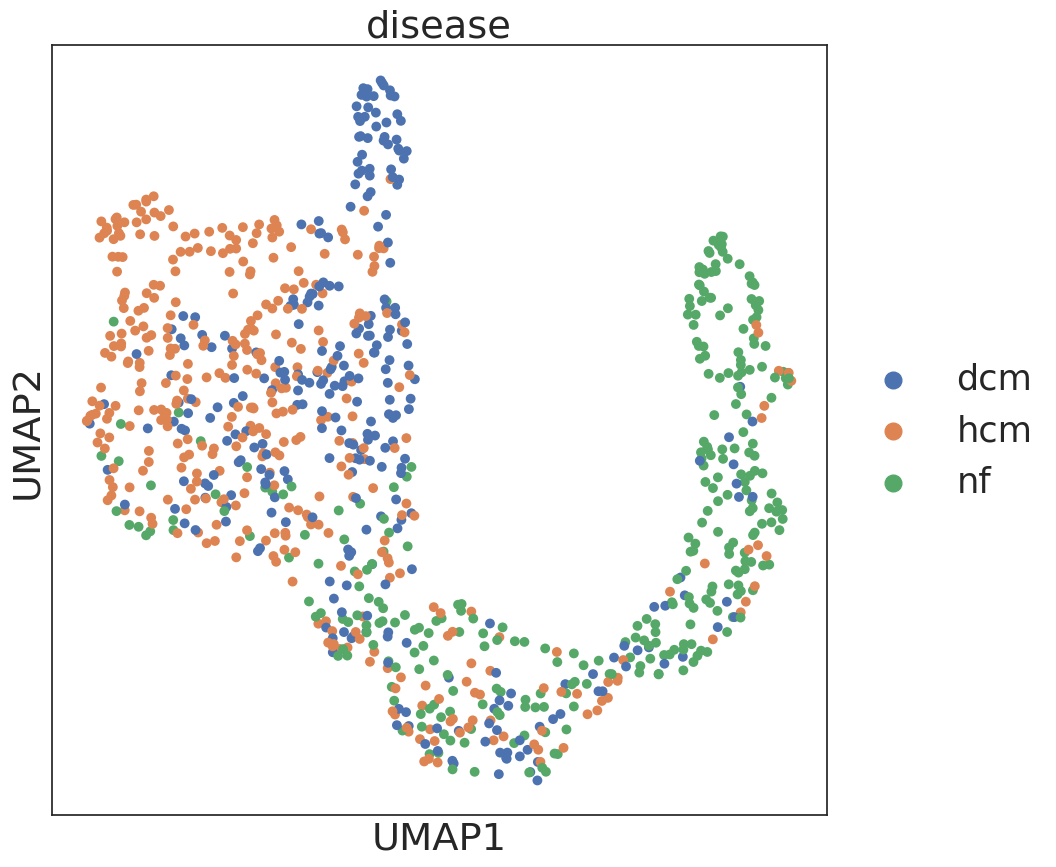

✅ V2 UMAP plot created!


<Figure size 1000x1000 with 0 Axes>

In [26]:
output_dir_embeddings = f"/content/cardiomyopathy_cell_classification_{datestamp_min}/"
output_prefix_descriptive = "cardio_disease_embeddings"

embex.plot_embs(
            embs=embs,
            plot_style="umap",
            output_directory=output_dir_embeddings,
            output_prefix=f"{output_prefix_descriptive}_umap"
        )
print("✅ V2 UMAP plot created!")

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2250x2250 with 0 Axes>

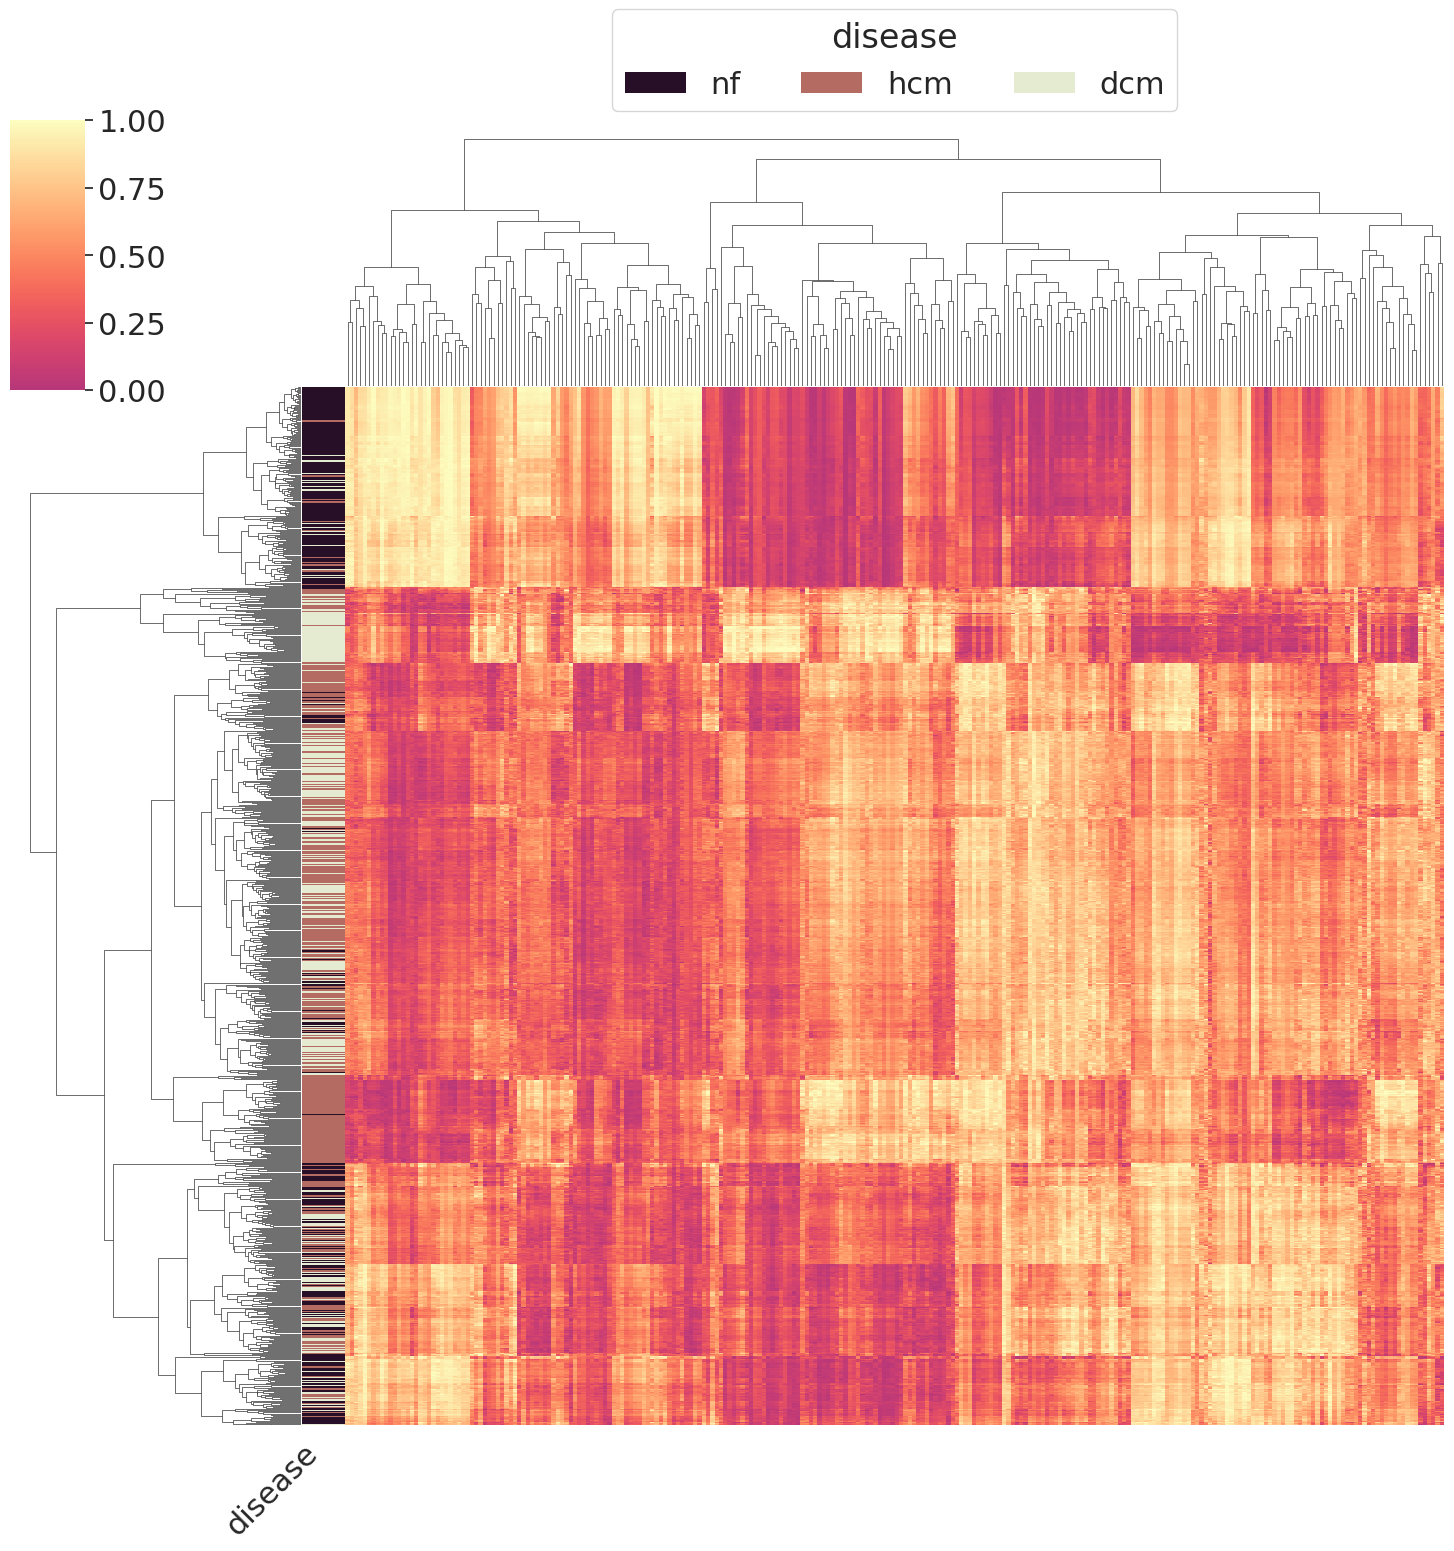

✅ Heatmap plot created!


<Figure size 1000x1000 with 0 Axes>

In [27]:
output_dir_embeddings = f"/content/cardiomyopathy_cell_classification_{datestamp_min}/"
output_prefix_descriptive = "cardio_disease_embeddings"

# plot heatmap of cell embeddings
embex.plot_embs(embs=embs,
                plot_style="heatmap",
                output_directory = output_dir_embeddings,
                output_prefix=f"{output_prefix_descriptive}_heatmap"
                )

print("✅ Heatmap plot created!")

In [28]:
!ls -1 /content/cardiomyopathy_cell_classification_250625

cardio_disease_embeddings.csv
cardio_disease_embeddings_heatmap_heatmap_disease.pdf
cardio_disease_embeddings_umap_umap_disease.pdf


In [29]:
embex
embs

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,disease
0,-0.379138,2.258647,0.104782,0.158437,-0.424063,0.418353,0.196079,-0.115070,-0.121506,-0.358453,...,-0.380129,0.632880,-0.033664,-1.309215,-0.998584,-0.689688,0.081392,0.613262,-2.084136,nf
1,2.447204,1.714956,0.368366,0.654517,0.007242,0.935064,-0.645116,-0.986527,0.075887,-1.079759,...,0.046983,0.000445,0.740064,-1.238707,0.423654,0.187429,-0.557549,1.156562,-2.426156,nf
2,-0.627251,1.409208,-0.185428,0.109135,-0.402817,0.174411,-0.603999,-0.148785,-0.458750,-0.145485,...,-0.393429,0.432248,0.213898,-1.080597,-0.839441,-0.335450,0.109809,0.769202,-1.862271,nf
3,-0.619056,1.272034,-0.251073,0.153464,-0.372574,0.185719,-0.645808,-0.170972,-0.512874,-0.161514,...,-0.375977,0.396910,0.280384,-1.057731,-0.807432,-0.271469,0.120091,0.813624,-1.832680,nf
4,2.842177,-0.240546,0.168337,0.487185,0.024565,1.266985,0.193490,-0.709378,0.027063,-0.766062,...,0.091754,-0.339672,1.030405,-0.676359,1.687174,0.899457,-0.491152,1.070792,-1.508292,hcm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.363525,2.959274,0.469567,-0.201397,-0.133199,0.689398,0.084221,-0.309705,0.544981,-0.771016,...,-0.091125,0.614964,0.140533,-1.044834,-0.947998,-0.664380,-0.459557,1.075368,-2.668029,hcm
996,0.611364,2.733451,0.582790,-0.225007,-0.244451,0.810758,0.320261,-0.376150,0.567728,-1.329212,...,0.041662,0.549748,0.221761,-0.884267,-0.970195,-0.675816,-0.384991,0.874623,-2.702306,dcm
997,2.205493,1.757926,0.571439,-0.302291,-0.173907,1.083693,0.084425,-0.551786,0.536583,-2.160519,...,0.305712,0.016167,0.600645,-0.966174,0.204429,-0.323759,-0.273018,1.360809,-2.875825,nf
998,0.965452,2.429846,0.473232,-0.396782,-0.278719,0.881355,0.519375,-0.353364,0.466550,-1.580940,...,0.299875,0.381543,0.141807,-0.736256,-0.925619,-0.651901,-0.177881,0.838310,-2.429001,hcm


**Here's an explanation of what you're seeing:**

*   **Rows (Indices 0 to 999)**: Each row corresponds to a single cell. The table shows 1000 rows, indicating that embeddings were extracted for 1000 cells, which aligns with your typical max_ncells=1000 setting in EmbExtractor.

*   **Columns (0 to 255): **These columns contain the numerical embedding values for each cell.

*   **An embedding** is a dense, low-dimensional vector representation of the input data (in this case, gene expression profiles of a cell). The values are floating-point numbers, typically ranging between -1 and 1 or similar.

*  The number of columns (256) indicates the dimensionality of the embeddings. This is the size of the vector used to represent each cell. For example, a Geneformer V1 model often produces embeddings of this size.

*  **disease Column:** This is an additional column on the far right, which likely contains the cell state label (disease status) for each cell (e.g., nf, hcm, dcm). This column was probably included because you specified *emb_label=["disease"]* or similar in your EmbExtractor initialization. It's crucial for downstream analysis and plotting, allowing you to color or group cells by their disease status.

In essence, these embeddings are the Geneformer model's learned numerical "fingerprints" for each cell. Cells with similar gene expression patterns (and thus similar biological states or disease statuses) are expected to have embedding vectors that are numerically "close" to each other in this 256-dimensional space. This makes them suitable for tasks like clustering, classification, and visualization (e.g., UMAP, t-SNE) to uncover biological insights.